# Basic Momentum
**Date:** 2025-05-17  
**Author:** Andrew Sutcliffe

I'll be implementing a basic 12-1 weekly rebalanced momentum strategy.

In [16]:
#Using external data from Hackathon for quality check.

import pandas as pd

df = pd.read_csv("stock_data.csv")

keep_cols = [
    "date", "permno", "stock_ticker", "comp_name",
    "market_equity", "ret_12_1", "ret_eom", "RF", "stock_exret", "year", "month"
]

df_small = df[keep_cols].copy()

df_small.head()

,date,permno,stock_ticker,comp_name,market_equity,ret_12_1,ret_eom,RF,stock_exret,year,month
0,2000-01-31,10001,NaN,NaN,20.825000,-0.062294,20000131,0.0041,-0.048218,2000,1
1,2000-01-31,10002,NaN,NaN,94.197187,-0.064491,20000131,0.0041,-0.029741,2000,1
2,2000-01-31,10009,NaN,NaN,34.028250,-0.098658,20000131,0.0041,-0.012575,2000,1
3,2000-01-31,10012,NaN,NaN,154.794312,7.000000,20000131,0.0041,-0.101376,2000,1
4,2000-01-31,10016,SCTT,SCOTT TECH INC,337.277375,0.247637,20000131,0.0041,-0.103438,2000,1


In [42]:
# Further shrink the dataset to the top 200 stocks by market cap

# Ensure date is datetime
df_small["date"] = pd.to_datetime(df_small["date"])

# Sort by date and market cap
df_sorted = df_small.sort_values(["date", "market_equity"], ascending=[True, False])

# Group by month and take top 200 by market cap
top200_df = df_sorted.groupby("date").head(200).copy()

# Optional: flag for clarity
top200_df["in_top200"] = True

print(top200_df.groupby("date").size().head())  # should be ~200 per date


date
2000-01-31    200
2000-02-29    200
2000-03-31    200
2000-04-28    200
2000-05-31    200
dtype: int64


In [43]:
# Basic Strategy: 

# 1. From top 200 universe, rank stocks by ret_12_1
# 2. Go long the top decile (top 20 stocks)
# 3. Compute the equal-weighted return for that decile in the following month using stock_exret

portfolio_rows = []

dates = sorted(top200_df["date"].unique())

for i in range(len(dates) - 1): 
    formation_date = dates[i]
    holding_date = dates[i + 1]

    # Get universe at formation date
    universe = top200_df[top200_df["date"] == formation_date].dropna(subset=["ret_12_1"])
    top_decile = universe.sort_values("ret_12_1", ascending=False).head(50)

    # Get returns for holding period
    holding_data = top200_df[top200_df["date"] == holding_date]

    for _, row in top_decile.iterrows():
        # Find the stock's return in the holding month
        stock_return = holding_data.loc[
            holding_data["permno"] == row["permno"], "stock_exret"
        ].values

        # If return is missing, set to NaN
        realized_exret = stock_return[0] if len(stock_return) > 0 else float("nan")

        portfolio_rows.append({
            "date": holding_date,
            "formation_date": formation_date,
            "permno": row["permno"],
            "stock_ticker": row["stock_ticker"],
            "comp_name": row["comp_name"],
            "ret_12_1": row["ret_12_1"],
            "market_equity": row["market_equity"],
            "realized_exret": realized_exret,
            "weight": 1 / 50  # Equal weight
        })

portfolio_df = pd.DataFrame(portfolio_rows)


In [44]:
# Calculate the portfolio return for each month:

# Group by date, compute sum of weighted returns
returns_df = portfolio_df.groupby("date").apply(
    lambda x: (x["weight"] * x["realized_exret"]).sum()
).reset_index(name="momentum_exret")


/var/folders/qt/dwz57vhd5szdmf7nm9yzzb800000gn/T/ipykernel_79180/3548526364.py:4: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  returns_df = portfolio_df.groupby("date").apply(


In [45]:
# Evaluate the portofolio performance:

# Compare with market
# Create a copy 
benchmark_df = top200_df[["date", "permno", "stock_exret", "market_equity"]].copy()

# Drop any missing market cap or returns
benchmark_df = benchmark_df.dropna(subset=["stock_exret", "market_equity"])

# Compute cap-weighted return per month
benchmark_df["weight"] = benchmark_df.groupby("date")["market_equity"].transform(lambda x: x / x.sum())
# Weighted sum of returns per month
cap_weighted_benchmark = benchmark_df.groupby("date").apply(
    lambda x: (x["weight"] * x["stock_exret"]).sum()
).reset_index(name="benchmark_exret")

# Merge into momentum returns DataFrame
returns_df = returns_df.drop(columns="benchmark_exret", errors="ignore")  
returns_df = returns_df.merge(cap_weighted_benchmark, on="date", how="left")


/var/folders/qt/dwz57vhd5szdmf7nm9yzzb800000gn/T/ipykernel_79180/1274599007.py:13: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  cap_weighted_benchmark = benchmark_df.groupby("date").apply(


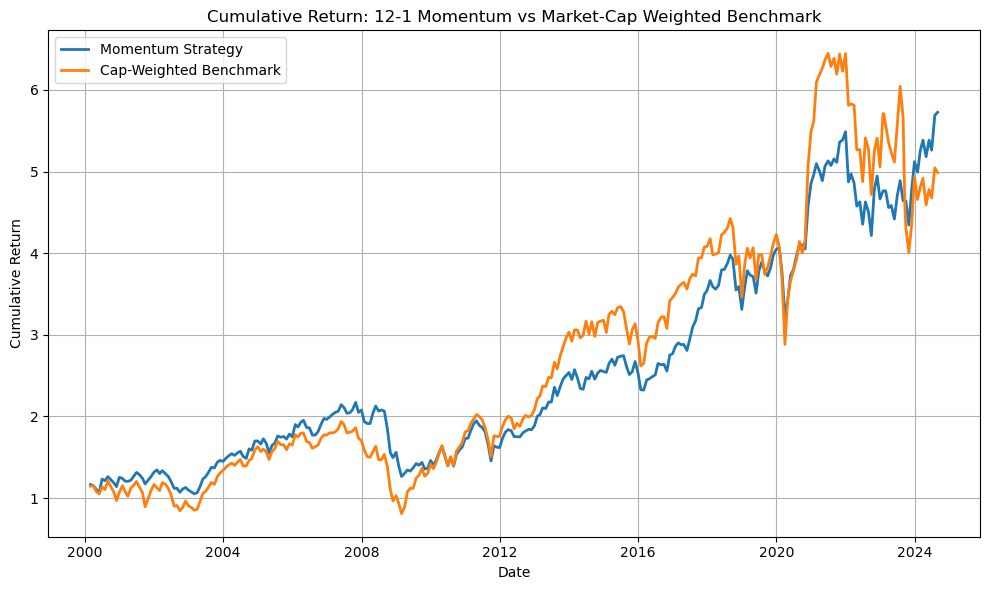

In [47]:
returns_plot = returns_df.set_index("date")[["momentum_exret", "benchmark_exret"]].copy()

# Compute cumulative return: (1 + r).cumprod()
cumulative_returns = (1 + returns_plot).cumprod()

import matplotlib.pyplot as plt

plt.figure(figsize=(10, 6))
plt.plot(cumulative_returns.index, cumulative_returns["momentum_exret"], label="Momentum Strategy", linewidth=2)
plt.plot(cumulative_returns.index, cumulative_returns["benchmark_exret"], label="Cap-Weighted Benchmark", linewidth=2)

plt.title("Cumulative Return: 12-1 Momentum vs Market-Cap Weighted Benchmark")
plt.xlabel("Date")
plt.ylabel("Cumulative Return")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()
